Log for the numerical experiments of the Frontal CI suite of experiments

# Jim's front
is characterized by
$$b(x, z) = b_0 + N^2_b(z+H) + \frac12 N^2_0 \left[(1 + \Gamma)z - (1 - \Gamma)\left(h(x) + \frac1\lambda \ln\cosh[(z - \eta + h(x))\lambda]\right)\right],$$
with
$$h(x) = h_0 - \frac{\delta h}{2}\text{erf}\left[\frac{x}\ell\right],$$
with x = 0 the center of the front, $\ell$ the half width, $h_0$ the central depth, and $\delta h$ the depth change across the front.
It is approximately the transition depth between the weak surface layer stratification (N^2_b) and the stronger pycnocline stratification (N^2_0).
The deeper boundary layer depth lies on the less strongly stratified, dense side of the front.

For purposes of illustration a typical set of parameter values is used for a submesoscale surface front:
$$f_0 = 0.78 \times 10^{-4}\ \text s^{-1};\quad h_0 = 60\ \text m;\quad \delta h = 15\ \text m;\quad N^2_0 = 3.4 \times 10^{-5}\ s^{-2} ;$$
$$N^2_b = 1.0 \times 10^{-6}\ s^{-2} ;\quad b_0 = 6.4 \times 10^{-3}\ m\,s^{-2} ;\quad \Gamma = 0.025 ;\quad \lambda^{-1} = 3\ \text m;$$

Note that $\ell$ has no value, I inferred $\ell = 1,000$ from Jim's figures.

In [1]:
import numpy as np                                                                                                                          
import matplotlib.pyplot as plt                                                                                                                                     
from scipy.special import erf

f0 = 0.78e-4  # [rad/s] Coriolis
delta_h = 15.  # [m]  amplitude of mixed layer depth change
h0 = 60.  # [m] mean mixed layer depth
N02 = 3.4e-5  # [rad/s]**2  pycnocline stratification
Nb2 = 1.e-6  # [rad/s]**2  mixed layer stratification
b0 = 6.4e-3  # [m/s**2]  some background buoyancy
Gamma = 0.025  # [ ]
lmbda = 1./3  # [1/m] "sharpness" of the vertical transition between Nb2 and N02
ell = 1.e3  # [1/m] frontal half-width, inferred from reading Jim's figures
eta = -0.  # [m] note sure what this is and it looks good without anyway

# Other, non-essential parameters
nx, nz = 512, 64
H = 100.  # [m] computational domain depth
Lx = 14.e3  # [m] computational domain width


# %% Create bases and domain --------------------------------------------------|
z = np.linspace(-H, 0., nz)
x = np.linspace(-Lx/2, Lx/2, nx)

ContArr = np.linspace(0.003, 0.0048, 32)  # array containing the countours

Z, X = np.meshgrid(z, x)

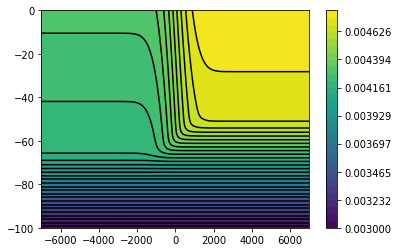

In [2]:
# Initial fields --------------------------------------------------------------|
h = h0 - 0.5*delta_h*erf(X/ell)
bi = (b0 + Nb2*(Z + H)  # initial b
      + .5*N02*((1 + Gamma)*Z - 
                (1 - Gamma)*(h + np.log(np.cosh(lmbda*(Z - eta + h)))/lmbda)))


# Plotting --------------------------------------------------------------------|
plt.figure(1)
plt.contourf(X, Z, bi, ContArr)
plt.colorbar()
plt.contour(X, Z, bi, ContArr, colors='k')
plt.xlim([-7.e3, 7.e3])
plt.ylim([-100, 0.])
plt.show()

Looks like the real thing.
Problems is that an asymmetric isolated front like this requires walls on the left and right side of the domain.
I tried with free-slip, no-cross-flow BCs (i.e., $\cos(n\pi/L_x)$ for $b$ and $w$, $\sin(n\pi/L_x)$ for $u$, $v$).

And the problem with walls is that 
* we cannot have hyperdiffusion operators because our sin/cos decomposition has 4 degrees of freedom, and the hyperdiffusion operators require more degrees of freedom at the boundaries for the problem to be fully set,
* Having both $u, v = 0$ at the borders create boundary layers, small scales, and apparently, instabilities.

I am not 100\% sure about the above two statements, but it is very hard to have stable simulations with the configuration above.

## Making things periodic

Actually fairly straightforward: if doing $x\to-x$ in the profile above:

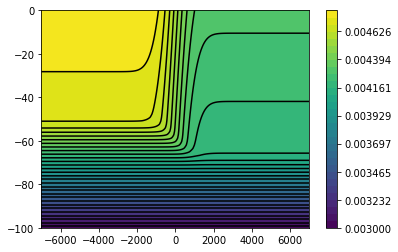

In [3]:
h2 = h0 - 0.5*delta_h*erf(-X/ell)
bi2 = (b0 + Nb2*(Z + H)  # initial b
       + .5*N02*((1 + Gamma)*Z - 
                 (1 - Gamma)*(h2 + np.log(np.cosh(lmbda*(Z - eta + h2)))/lmbda)))


# Plotting --------------------------------------------------------------------|
plt.figure(2)
plt.contourf(X, Z, bi2, ContArr)
plt.colorbar()
plt.contour(X, Z, bi2, ContArr, colors='k')
plt.xlim([-7.e3, 7.e3])
plt.ylim([-100, 0.])
plt.show()

Then, in $h$, shift the two profiles, add the $\text{erf}$'s minus one:
$$h_3 = h_0 - \frac{\delta_h}2\left[\text{erf}\left(-\frac{x-D}{\ell}\right) + \text{erf}\left(\frac{x+D}\ell\right) - 1\right],$$
where $D$ is the half-distance betwen the fronts, and replace $h$ by $h_3$ in the original expression for $b$.

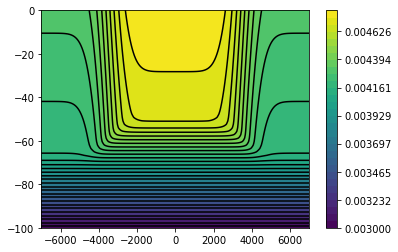

In [4]:
D = 3.5e3
ell2 = ell
h3 = h0 - 0.5*delta_h*(erf(-(X-D)/ell2) + erf((X+D)/ell) - 1.)
bi3 = (b0 + Nb2*(Z + H)  # initial b
       + .5*N02*((1 + Gamma)*Z - 
                 (1 - Gamma)*(h3 + np.log(np.cosh(lmbda*(Z - eta + h3)))/lmbda)))


# Plotting --------------------------------------------------------------------|
plt.figure(2)
plt.contourf(X, Z, bi3, ContArr)
plt.colorbar()
plt.contour(X, Z, bi3, ContArr, colors='k')
plt.xlim([-Lx/2, Lx/2])
plt.ylim([-100., 0.])
plt.show()

# Log

## Technical details

### Processing procedure

On NGWS2015:
* Using dedalus, installed the 'conda way': https://dedalus-project.readthedocs.io/en/latest/installation.html#conda-installation
(note that the base environment has to be deactivated before activating the dedalus environment).
* activate dedalus: `conda activate dedalus`
* As of Feb 2019, the data is transfered from Niagara to NGWS2019 on `/data1/nicolas/`, but the processing happens on the main drive. Do the following:

`cd ~/dedalus-vessel/dd_tests/`

can open `process.bash` to check that it will fetch data on `/data1`. If you only have one experiment to process, execute it (just execute first, read the error message, then use the proper arguments).
If you have more than one experiment to process, open `process-loop.bash` to adjust which experiments are scheduled for process, and execute that one instead.

## Test_Jim_01

I forgot

## Test_Jim_02

### Physical parameters

* $f_0 = 0.78\times 10^{-4}$ rad s  (Coriolis)
* $\delta_h = 15$ m  (amplitude of mixed layer depth change)
* $h_0 = 60$ m (mean mixed layer depth)
* $N_0^2 = 3.4\times 10^{-5}$  rad s$^{-2}$ (pycnocline stratification)
* $N_b^2 = 10^{-6}$  rad s$^{-2}$  (mixed layer stratification)
* $b_0 = 6.4\times 10^{-3}$ m s$^{-2}$  (some background buoyancy)
* $\Gamma = 0.025$  (not sure actually... controls the shape)
* $\lambda = 1/3$ m$^{-1}$  ("sharpness" of the vertical transition between $N_b^2$ and $N_0^2$)
* $\ell = 1,000$ m$^{-1}$  (frontal half-width, inferred from reading Jim's figures)
* $\eta = -0.$  m (another shape factor, it looks good without anyway)
* **one-sided front**

* $\nu_z = 10^{-4}$ m$^2$ s$^{-1}$
* $\nu_h = 10^{-2}$ m$^2$ s$^{-1}$
* $\nu_{h2} = 10^{8}$  m$^{6}$ s$^{-1}$

* $H = 150$ m  (computational domain depth
* $L_x = 10$ km (computational domain width)

* Initial $\phi$ found by integrating the initial (de-noised) $b$ as a dedalus BVP during the first time step. The $x$-parity of $\phi$ is the same as that of $b$. Initial $v$ and $\partial_z v$ are computed by differentiating this value.

### Implementation details

#### Domain

* `x_basis = de.SinCos('x', 5120, interval=(-Lx/2, Lx/2))  # , dealias=3/2)`

    `z_basis = de.Chebyshev('z', 1280, interval=(-H, 0.))  # , dealias=3/2)`

* `pb = de.IVP(domain, variables=['u', 'uz', 'v', 'vz', 'w', 'wz', 'b', 'bz', 'p'])`

    `pb.meta['uz', 'vz', 'w', 'bz']['z']['dirichlet'] = True`

    `Parities = {'u': -1, 'w': +1}  # ?: cos; ?: sin`
    
    `pb.meta['u', 'uz', 'v', 'vz']['x']['parity'] = Parities['u']`
    
    `pb.meta['w', 'wz', 'b', 'bz', 'p']['x']['parity'] = Parities['w']  # cos(kz)`
    
* Boundary conditions in $z$:
    * $z = 0$: free-slip, rigid lid, no-flux boundary conditions:
        $$\frac{\partial b}{\partial z} = \frac{\partial v}{\partial z} = \frac{\partial u}{\partial z} = w = 0.$$
    * $z = -H$: free-slip, rigid lid, no-flux boundary conditions:
        $$\frac{\partial b}{\partial z} = \frac{\partial v}{\partial z} = \frac{\partial u}{\partial z} = w = 0.$$
    * Pressure: `pb.add_bc("right(p) = 0", condition="(nx == 0)")  # z-averaged mode is zero`
    
    Note that this is not satisfying. There should be flux and stress conditions on top and bottom, and the dirichlet BCs should be set with more variables.

#### Time stepping

* `RK443`
* $dt = 10$ s (initial timesteps)
* $t_{end} = 10\times 2\pi/f_0$  (irrelevant, never reached)
* walltime max $= 15$ min  (stop the calculation if it goes too far)
* max number of iterations $= \infty$  (stop the calculation if it goes too far)

#### Analysis

* `snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=100*dt, max_writes=200)`
* `flow.add_property("4*bz - (uz**2 + vz**2)", name='Ri_red')`. If `Ri_red` is a `NaN` of `inf`, we raise a `NameError`.

## Test_Jim_03

### Physical parameters

* **two-sided front**
* $\nu_{h2} = 10^{6}$  m$^{6}$ s$^{-1}$
* $L_x = 14$ km (computational domain width)
* $H=100$ m (computational domain depth)
* $D = 3.5$ km (half-distance between the fronts) 

The rest is the same as `Test_Jim_02`

### Implementation details

#### Domain

* `x_basis = de.Fourier('x', 5120, interval=(-Lx/2, Lx/2))  # , dealias=3/2)`
* $x$-parities become irrelevant in a periodic domain.
* BCs in $z$ still need fixing.

## Test_Jim_04

In this test run, I will test how fast it is to run grids of (a) $4096\times1024$, (b) $4096\times1280$, (c) $5120\times1024$ and (d) $5120\times1280$. One of them should be markedly faster than the others, regardless of grid size.

The reason is that I am not 100% certain which dimension should have a multiple of 80 to accomodate for the 80-tasks-per-node minimum of Niagara, if any, or if both should.

I will only run for half an inertial period to let the simulation finish, and I will not print out anything by commenting out all of the lines related to snapshots (hence re-running $5120\times1280$, whichy is essentially Test_Jim_03). Instead, I will only time the execution.

### Implementation details


#### Time stepping

$t_{end} = 0.5\times 2\pi/f_0$  (to let the simulation finish)

#### Domain

* BCs in $z$ still need fixing.

### Results

(a) $4096\times1024\Rightarrow$ with 80 tasks/node 21:49, or $3.12 \times 10^{-4}$ s/(grid point).

(b) $4096\times1280\Rightarrow$ with 80 tasks/node 26:16, or $3.00 \times 10^{-4}$ s/(grid point).

(c) $5120\times1024\Rightarrow$ with 80 tasks/node 26:08, or $2.99 \times 10^{-4}$ s/(grid point).

(d) $5120\times1280\Rightarrow$ with 80 tasks/node 31:44, or $2.91 \times 10^{-4}$ s/(grid point).

(e) $4096\times1024\Rightarrow$ with 72 tasks/node: 22:26, or $3.21 \times 10^{-4}$ s/(grid point).

(f) $4096\times1024\Rightarrow$ with 36 tasks/node: 25:54, or $3.71 \times 10^{-4}$ s/(grid point).

(g) $4096\times1024\Rightarrow$ with 64 tasks/node: 24:11, or $3.46 \times 10^{-4}$ s/(grid point).

(h) $4096\times1024\Rightarrow$ with 40 tasks/node: 24:19, or $3.48 \times 10^{-4}$ s/(grid point).

(i) $4096\times1024\Rightarrow$ with 128 tasks/node: `SBATCH: error: CPU count per node can not be satisfied`

(j) $5120\times1280\Rightarrow$ with 40 tasks/node: 34:53, or $3.19 \times 10^{-4}$ s/(grid point).

Verdict is, let's use $5120\times1280$ with 80 tasks/node.

## Test_Jim_05

Here we test the time stepping scheme. Choices are:
* `RK443` (RK)
* `RK222` (RK)
* `RK111`
* `CNLF2` (Crank-Nicolson for implicit, Leap Frog for explicit)
* `CNAB1` (Crank-Nicolson for implicit, Adams-Bashforth for explicit)
* `CNAB2` (Crank-Nicolson for implicit, Adams-Bashforth for explicit)
* `CNLF1` (Crank-Nicolson Leap Frog 1)
* `MCNAB2`
* `RKSMR`
* `SBDF1`
* `SBDF2`
* `SBDF3`
* `SBDF4`

*Note: the classes* `MultistepIMEX`, `RungeKuttaIMEX`, `FieldSystem`, `CoeffSystem`, `deque` *and* `CoeffSystem` *are not time stepping schemes.*

I will try them all out of curiosity.

I also restore a higher output frequency, in order to see what the solutions look like:

`snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1000*dt,
                                               max_writes=200)`


### Implementation details


#### Time stepping

* $t_{end} = 2\times 2\pi/f_0$  (to let the simulation finish)

#### Domain

* BCs in $z$ still need fixing.

### Results

(a) `RK222` (based on `Test_Jim_04_d`): Ri exception after 2:53:37; `Iteration: 1721, Time: 8.913770e+04, dt: 5.220164e+00`

(b) `RK443`: Hit walltime limit after 3:00:00; `Iteration: 1591, Time: 8.804413e+04, dt: 1.179124e+01`

(c) `RK111`: Ri exception after 1:24:28; `Iteration: 1601, Time: 8.853748e+04, dt: 1.165061e+01`

(d) `CNAB1`: 11:52 Ringing

(e) `CNAB2`: 08:45 Ringing

(f) `MCNAB2`: Ri exception after 00:30:15; `Iteration: 561, Time: 7.038754e+04, dt: 2.732291e+01`

(g) `RKSMR`: Hit walltime limit after 3:00:00; `Iteration: 1181, Time: 8.173491e+04, dt: 1.725298e+01`

(h) `SBDF1`: ??

(i) `SBDF2`: Ri exception after 1:00:28; `Iteration: 671, Time: 7.286953e+04, dt: 1.990431e+01`

(j) `SBDF3`: Ri exception after 00:31:45; `Iteration: 511, Time: 6.889054e+04, dt: 3.274125e+01`

(k) `SBDF4`: Ri exception after 00:25:07; `Iteration: 431, Time: 6.570265e+04, dt: 4.657807e+01`

(l) `CNLF2`: 06:44 Ri exception very early.

## Test_Jim_06

I settled on RK222 (443?) and play with dealiasing.

### Implementation detail

#### Domain

* Definition of the bases is now:

`x_basis = de.Fourier('x', 5120, interval=(-Lx/2, Lx/2), dealias=3/2)`

`z_basis = de.Chebyshev('z', 1280, interval=(-H, 0.), dealias=3/2)`

In later runs, I will investigate how far I can get in terms of resolution vs. viscosity.

### Results

`Iteration: 551, Time: 6.431368e+04, dt: 3.534208e+01`

Compared to case above, `dt` is longer now, and the physical time is about the same.

![Test_Jim_06](TJ_06_000008.png)

## Test_Jim_07

I focus the frontal zone to the unstable regions, I reduce the viscosity, and increase the computing time cto 8 hours.

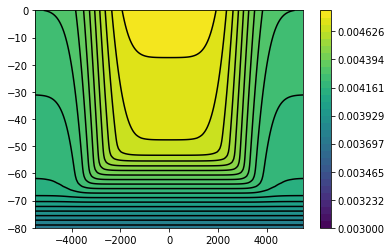

In [5]:
H = 80.  # [m] computational domain depth
D = 3e3
Lx = 11.e3  # [m] computational domain width

# %% Create bases and domain --------------------------------------------------|
z = np.linspace(-H, 0., nz)
x = np.linspace(-Lx/2, Lx/2, nx)
Z, X = np.meshgrid(z, x)

h3 = h0 - 0.5*delta_h*(erf(-(X-D)/ell2) + erf((X+D)/ell) - 1.)
bi3 = (b0 + Nb2*(Z + H)  # initial b
       + .5*N02*((1 + Gamma)*Z - 
                 (1 - Gamma)*(h3 + np.log(np.cosh(lmbda*(Z - eta + h3)))/lmbda)))


# Plotting --------------------------------------------------------------------|
plt.figure(3)
plt.contourf(X, Z, bi3, ContArr)
plt.colorbar()
plt.contour(X, Z, bi3, ContArr, colors='k')
plt.xlim([-Lx/2, Lx/2])
plt.ylim([-H, 0.])
plt.show()

Other changes: 
`nuz = 1e-5`,
`nuh = 1e-4`,
`nuh2 = 1e5`.

![Test_Jim_07](TJ_07_000008.png)
![Test_Jim_07](TJ_07_000012.png)

Dealiasing in `Test_Jim_07` way too important, and crashes anyway.

## Test_Jim_08

Same as 07, but I multiply all (hyper)viscosities by 10:
`nuz = 1e-4`, `nuh = 1e-3`, `nuh2 = 1e6` (may want to adjust `nuh` or `nuh2` down).

Result: silky smooth, ran for 24 hours, final frame at 170,000 s, final dt = 8.312416 s and going down actually, but not by much.

Initial dt goes oup to 600 s, maybe start there (does make much of a difference anyway).

**This is the new reference.**

## Test_Jim_09

Same as 07, but (hyper)viscosities are
`nuz = 2.5e-5`, `nuh = 2.5e-4`, `nuh2 = 1e6` (hyper is the same).

Result: lots of grid-scale noise. Ran for 24 hours, final frame at 130,000 s, final dt=XXXX.

## Test_Jim_10

Same as 07, but (hyper)viscosities are
`nuz = 5e-5`, `nuh = 5e-4`, `nuh2 = 1e6` (hyper is the same, **may want to consider lowering nuh2**).

Some gridscale noise. Ran for 24 hours, final frame at 170,000 s, final dt=XXXX.

## Test_Jim_zBC

I now try fixing the boundary conditions in $z$, though locally.

All physical parameters (grid size, viscosities, etc.) are those of `Test_Jim_07`. 

Weird instability (columnar structures, not sure if they are internal waves; it is also asymmetric, the left jet is more unstable than the right jet). Here is what I tried:
* cleaned up the initial conditions by removing some redundancies;
* sat `max_dt=100.` in `flow_tools.CFL` (goes up to >1000 s here and, while it hovers around 10 s when the instability is in full swing in Test_Jim_08). The code ran, with some ringing again.

### Implementation detail

#### Domain

* Boundary conditions in $z$: all vertical derivatives are restored to their initial derivatives, instead of zero (though $\partial u/\partial z =0$ still).
* Contrary to what I wrote earlier, I will not change the Dirichlet pre-conditioning.

## At this point, I was investigating...

* moved to Graham in order to use $2^n$ processors, then failed.
* [GRA] I placed these experiments in a directory called `rob`, for "robustness" [to ISI]. `master-core-gra.bash` understand paths now:

    `./master-core-gra.bash rob/2D_2048_VAN 64 0-23:59`
    
    works.
* [NIA] I also placed these experiments in a directory called `rob`, for "robustness" [to ISI]. `master-core-nia.bash` understand paths now:

    `./master-core-gra.bash rob/2D_2560_VAN 1 0-23:59`
    
    works.
* Re-named setup folder names: `2D_N_BC`, with `N` the number of modes in the horizontal and `BC` being one of 
    * `VAN`: "vanilla" boundary conditions ($\partial_z v = \partial_z\bar v$ and $\partial_z b = \partial_z\bar b$ like in Taylor & Ferrari 2009, or `Test_Jim_zBC`).
    * `NF`: free slip ($\partial_z v = 0$), no flux ($\partial_z b = 0$) boundary conditions.
    * `KW`: free slip ($\partial_z v = 0$), attached isopycnals ($b = \bar b$) boundary conditions (like in Kraig Winter's code).
    
* Outstanding priorities are:
    * get to the end of a lifetime (increase number of nodes and decrease resolution),
    * Try 3D

## 2D_2560_VAN_01

* `nuz = 4e-4`, `nuh = 4e-3`, `nuh2 = 1e7`
* Changed the adaptive time stepping options from 
```
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=1,
                     max_change=1.5, min_change=0.5, max_dt=4000.,
                     threshold=0.05)
```
to 
```
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.8,
                     threshold=0.05, max_change=1.5)```
* Investigating if some aliaising is happening. I think so.
* The run was successful (though not quite 10 inertial periods in 24 hours and 1 core but almost), I am saving this one and trying to increase the horizontal $\nu_{h2}$ and decrease the vertical $\nu_z$.


## 2D_2560_VAN_02

* `nuz = 1e-4`, `nuh = 4e-3`, `nuh2 = 1e7`
* Requesting 12 hours of walltime on 2 cores.

I think it works, if ignoring the ringing.

## 2D_2560_VAN_03

* `nuz = 4e-4`, `nuh = 4e-3`, `nuh2 = 1e8`
* Requesting 13 hours of walltime on 2 cores. Ran in 11h30.

Result: too viscous, horizontally.

## 2D_2560_VAN_04

* `nuz = 1e-4`, `nuh = 4e-3`, `nuh2 = 1e8`
* Requesting 13 hours of walltime on 2 cores. There was a problem and it did not run very far, but I will not resubmit.

Result: too viscous, horizontally.

## 2D_2560_VAN_05

* `nuz = 1e-4`, `nuh = 4e-3`, `nuh2 = 2e7`
* Requesting 12 hours of walltime on 2 cores.


# Doodle about 3D domain

## Grid

In [6]:
a = 640*160*320
b = a//80
c = b//5

In [7]:
640/8

80.0

We can use two cores (160 processes) and divide the long ($x$) direction into 16 and the short ($y$) direction into 10, and vice-versa.

The way to do it is

> Add mesh=(px, py) keyword to the Domain object, where px and py are the number of cores for x and y (here I'm assuming z is the chebyshev direction).

according to Jeff Oishi (https://groups.google.com/d/msg/dedalus-users/kF2Vg7zz67k/1Tm4ucbbAQAJ). So, that's what we are doing:

`x_basis = de.Fourier('x', nx, interval=(-Lx/2, Lx/2), dealias=3/2)`

`y_basis = de.Fourier('y', ny, interval=(-Ly/2, Ly/2), dealias=3/2)`

`z_basis = de.Chebyshev('z', nz, interval=(-H, 0.), dealias=3/2)`

`domain = de.Domain([x_basis, y_basis, z_basis], grid_dtype=np.float64,
                   mesh=(16, 10))`

`x, y, z = domain.grids(scales=1)`

We have to request 2 cores for this one then.

## Initial condition

We are cutting it close, and we will have to make one front stable.

In [8]:
%reset
import numpy as np                                                                                                                          
import matplotlib.pyplot as plt                                                                                                                                     
from scipy.special import erf
from scipy.integrate import cumtrapz

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [9]:
f0 = 0.78e-4  # [rad/s] Coriolis
delta_h = 15.  # [m]  amplitude of mixed layer depth change
h0 = 60.  # [m] mean mixed layer depth
N02 = 3.4e-5  # [rad/s]**2  pycnocline stratification
Nb2 = 1.e-6  # [rad/s]**2  mixed layer stratification
b0 = 6.4e-3  # [m/s**2]  some background buoyancy
Gamma = 0.025  # [ ]
lmbda = 1./3  # [1/m] "sharpness" of the vertical transition between Nb2 and N02
ell = 1.e3  # [1/m] frontal half-width, inferred from reading Jim's figures
eta = -0.  # [m] note sure what this is and it looks good without anyway

# Other, non-essential parameters
nx, nz = 320, 160
H = 80.  # [m] computational domain depth
Lx = 8.e3  # [m] computational domain width


# %% Create bases and domain --------------------------------------------------|
z = np.linspace(-H, 0., nz)
x = np.linspace(-Lx/2, Lx/2, nx)

ContArr = np.linspace(0.003, 0.0048, 32)  # array containing the countours

Z, X = np.meshgrid(z, x)

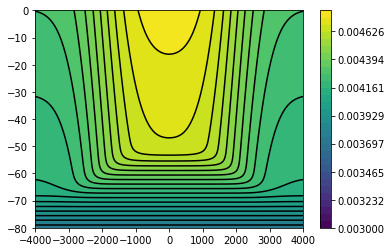

In [10]:
D = 2e3
ell2 = ell
h3 = h0 - 0.5*delta_h*(erf(-(X-D)/ell2) + erf((X+D)/ell) - 1.)
b = (b0 + Nb2*(Z + H)  # initial b
     + .5*N02*((1 + Gamma)*Z - 
               (1 - Gamma)*(h3 + np.log(np.cosh(lmbda*(Z - eta + h3)))/lmbda)))


# Plotting --------------------------------------------------------------------|
plt.figure(2)
plt.contourf(X, Z, b, ContArr)
plt.colorbar()
plt.contour(X, Z, b, ContArr, colors='k')
plt.xlim([-Lx/2, Lx/2])
plt.ylim([-80., 0.])
plt.show()

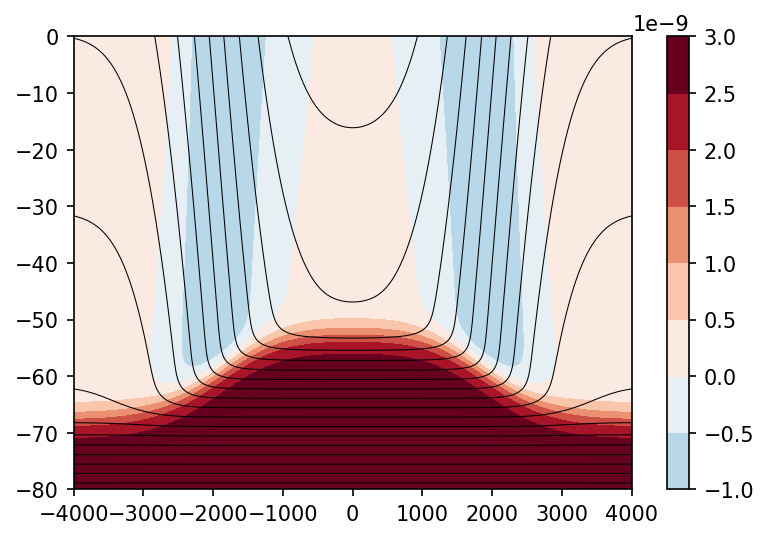

In [11]:
# Plotting the PV ---------------------------------------------------------------|
dbdx = np.gradient(b, x, axis=0)
dbdz = np.gradient(b, z, axis=1)

v = cumtrapz(dbdx/f0, Z, initial=0.)
dvdx = np.gradient(v, x, axis=0)
dvdz = np.gradient(v, z, axis=1)

Q = (f0+dvdx)*dbdz - dbdx**2/f0
Qmax = abs(Q).max()

plt.figure(3, dpi=150)
plt.contourf(X, Z, Q, cmap='RdBu_r', vmin=-Qmax, vmax=Qmax)
plt.colorbar()
plt.contour(X, Z, b, ContArr, colors='k', linewidths=0.5)
plt.xlim([-Lx/2, Lx/2])
plt.ylim([-H, 0.])
plt.show()

## 3D_640_VAN_01

As the first 3D run, we need to define a lot.

### Physical parameters

Same as `2D_2560_VAN_01`, except

* $Lx = 8$ km
* $D = 2$ km
* $dx = Lx/nx$, $Ly = dx\times ny$ (so that $dx=dy)$
* $\nu_z = 10^{-2}$ m$^2/$s
* $\nu_h = 10^{-3}$ m$^2/$s
* $\nu_{h2} = 10^9$ m$^6/$s

### Implementation details

#### Domain

* bases and distribution: see above, in the doodle section.
* Grid: `nx=640`, `ny=320`, `nz=320`.
* `pb = de.IVP(domain, variables=['u', 'uz', 'v', 'vz', 'w', 'wz', 'b', 'bz', 'p'], time='t')`
* Non-linear and diffusion operators:

Yup.
* Set of equations:

    
#### Time stepping

* `RK222` again
* $dt = 100$ s (initial timesteps)
* $t_{end} = 2\pi/f_0$ (just to test if everything OK)

#### Analysis

We print out a full state every 1000 iterations, 2D slices every 100 iterations, and a 3D map of coefficients for $\partial_z u$ every 1000 iterations.

## Immediate tests

We should try four horizontal resolutions/distributions:
* $640\times320$ with $16\times 10$ cores, (`3D_640_VAN_01`)
* $640\times320$ with $20\times 8$ cores, (`3D_640_VAN_02`)
* $640\times256$ with $16\times 10$ cores, (`3D_640_VAN_03`)
* $640\times256$ with $20\times 8$ cores, (`3D_640_VAN_04`)

Outstanding question for myself: `x, y, z = domain.grids(scales=1)`: does it take into account dealiasing?